In [ ]:
try:
  from nilearn import datasets
  from nilearn import plotting
except:
  !pip install nilearn==0.9.2
  from nilearn import datasets
  from nilearn import plotting
import numpy as np
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression
from sklearn.base import clone



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 37.7 MB/s eta 0:00:00


In [ ]:
#Get algonauts NSD data
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
main_dir = '/content/drive/MyDrive/ANNs/UvA_encodingtutorial'
fmri_dir = os.path.join(main_dir, 'fmri_data')
stim_dir = os.path.join(main_dir, 'stimuli')
# make sure the main dir exists (i.e., check that the above worked)
assert os.path.isdir(main_dir)

Mounted at /content/drive/


In [ ]:
#Define functions to deal with ROIs and plotting brains
def get_roi_mask(roi, hemisphere, subj_dir):
  # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'
  elif roi == 'all-vertices':
      roi_class = 'all-vertices'
  else:
      raise ValueError('Invalid ROI name.')

    # Load the ROI brain surface maps
  fsaverage_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')

  fsaverage_roi_class = np.load(fsaverage_roi_class_dir)

  if roi != 'all-vertices':
    algonauts_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')

    algonauts_roi_class = np.load(algonauts_roi_class_dir)

    roi_map_dir = os.path.join(subj_dir, 'roi_masks',
        'mapping_'+roi_class+'.npy')
    roi_map = np.load(roi_map_dir, allow_pickle=True).item()

    # Select the vertices corresponding to the ROI of interest
    roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
    algonauts_roi = np.asarray(algonauts_roi_class == roi_mapping, dtype=int) # ROI definitions with only the algonauts visual area vertices
    fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int) # ROI definitions with all the full brain fsaverage vertices

    return algonauts_roi, fsaverage_roi

  else:
    return None, fsaverage_roi_class


def plot_brainmap(fmri_data, roi, map_type, hemisphere, subj_dir, title=None):

  algonauts_roi, fsaverage_roi = get_roi_mask(roi, hemisphere, subj_dir)

  if fmri_data is None:
    fsaverage_response = fsaverage_roi
    cmap = 'cool'
    colorbar = False
  else:
    fsaverage_response = np.zeros(len(fsaverage_roi))
    if roi != 'all-vertices':
      # We need to find which fsaverage vertices correspond to the algonauts vertices, and fill in data there
      # if you are confused, don't hesitate to print shapes and think/ask about it.
      fsaverage_response[np.where(fsaverage_roi)[0][:len(np.where(algonauts_roi)[0])]] =  fmri_data[np.where(algonauts_roi)[0]]
    else:
      fsaverage_response[np.where(fsaverage_roi)[0]] = fmri_data
    cmap = 'cold_hot'
    colorbar = True

  if title is None:
    title = roi+', '+hemisphere+' hemisphere'

  # Create the interactive brain surface map
  fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
  view = plotting.view_surf(
      surf_mesh=fsaverage[map_type+'_'+hemisphere],
      surf_map=fsaverage_response,
      bg_map=fsaverage['sulc_'+hemisphere],
      threshold=1e-14,
      cmap=cmap,
      colorbar=True,
      title=roi+', '+hemisphere+' hemisphere'
      )
  return view


load the fMRI data for a subject

In [ ]:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

# Define paths for the subject
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')
lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(872, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(872, 20544)
(Training stimulus images × RH vertices)


In [ ]:
#Get a DNN to use for our encoding model
#EfficientNet the pretrained weights
# get the pretrained weights (cf. torchvision online documentation for other models)
effNet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# the weights contain the preprocessing transforms! Very handy.
effNet_transforms = effNet_weights.transforms()
# instantiate model
effNet_model = torchvision.models.efficientnet_b0(weights=effNet_weights)
# put model on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effNet_model.to(device)
# use model in evaluation mode (i.e., dropout is not applied, etc.)
effNet_model.eval()
print(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


cuda


In [ ]:
#training/testing image dataloaders
stim_dir = os.path.join(main_dir, 'stimuli')

# Create lists with all training and test image file names, sorted
img_list = os.listdir(stim_dir)
img_list.sort()
print('Total n. of images: ' + str(len(img_list)))

Total n. of images: 872


In [ ]:
# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(img_list) / 100 * 90))
# Shuffle all stimulus images
idxs = np.arange(len(img_list))
np.random.shuffle(idxs)

# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_test = idxs[:num_train], idxs[num_train:]

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nTest stimulus images: ' + format(len(idxs_test)))


Training stimulus images: 785

Test stimulus images: 87


In [ ]:
#we create an ImageDataset class, which will have the functions needed to turn our .png folder into a Dataset understood by pytorch
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

In [ ]:
#we can pass instances off this custom ImageDataset class to make DataLoaders
batch_size = 50 #@param

# Get the paths of all image files
imgs_paths = [stim_dir + '/' + x for x in sorted(os.listdir(stim_dir))]

# The DataLoaders use the ImageDataset class we defined earlier
train_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_train, transform=effNet_transforms),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_test, transform=effNet_transforms),
    batch_size=batch_size
)

In [ ]:
#split the fMRI data into training/testing
# Make train/test splits for the fMRI data for the two hemispheres
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_test = rh_fmri[idxs_test]


In [ ]:
#Gathering model activities for the training images
train_nodes, _ = get_graph_node_names(effNet_model)
print(train_nodes)
model_layer = "avgpool"
feature_extractor = create_feature_extractor(effNet_model, return_nodes=[model_layer])

['x', 'features.0', 'features.1.0.block.0', 'features.1.0.block.1', 'features.1.0.block.2', 'features.2.0.block.0', 'features.2.0.block.1', 'features.2.0.block.2', 'features.2.0.block.3', 'features.2.1.block.0', 'features.2.1.block.1', 'features.2.1.block.2', 'features.2.1.block.3', 'features.2.1.stochastic_depth', 'features.2.1.add', 'features.3.0.block.0', 'features.3.0.block.1', 'features.3.0.block.2', 'features.3.0.block.3', 'features.3.1.block.0', 'features.3.1.block.1', 'features.3.1.block.2', 'features.3.1.block.3', 'features.3.1.stochastic_depth', 'features.3.1.add', 'features.4.0.block.0', 'features.4.0.block.1', 'features.4.0.block.2', 'features.4.0.block.3', 'features.4.1.block.0', 'features.4.1.block.1', 'features.4.1.block.2', 'features.4.1.block.3', 'features.4.1.stochastic_depth', 'features.4.1.add', 'features.4.2.block.0', 'features.4.2.block.1', 'features.4.2.block.2', 'features.4.2.block.3', 'features.4.2.stochastic_depth', 'features.4.2.add', 'features.5.0.block.0', 

Incremental PCA for our DNN activations
To avoid overfitting, we use principal component analysis (PCA), the most common form of dimensionality reduction. We reduce the dimensions to 50, a more manageable number.

we use incremental PCA, to fit PCA batch by batch instead of fitting on the whole [n_stimuli x n_dnn_activities] matrix.
we defined a function that does the following:

Declare our IncrementalPCA instance.
Loops over batches of images.
For each batch, we extract the DNN activities, yielding an [n_batch_imgs, n_dnn_activities] matrix.
Apply one step of incremental pca to that batch of activities
The function returns the fitted PCA instance.

In [ ]:
def fit_pca(feature_extractor, dataloader, batch_size, n_components=50):

    # Define PCA parameters
    pca = IncrementalPCA(n_components, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        if d.shape[0] < n_components:
            # the last batch can be smaller. If it is smaller than n_components,
            # PCA cannot run so we skip
            continue
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [ ]:
pca = fit_pca(feature_extractor, train_imgs_dataloader, batch_size,
              n_components=min(batch_size, 50))

100%|██████████| 16/16 [10:27<00:00, 39.21s/it]


In [ ]:
#Extracting DNN activations
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)


In [ ]:
features_train = extract_features(feature_extractor, train_imgs_dataloader,pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

100%|██████████| 2/2 [01:03<00:00, 31.59s/it]


Fitting the encoding model

In [ ]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_test_pred = reg_rh.predict(features_test)

In [ ]:
# Empty correlation array of shape: (LH vertices)
lh_correlation_effNet = np.zeros(lh_fmri_test_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_test_pred.shape[1])):
    lh_correlation_effNet[v] = pearsonr(lh_fmri_test_pred[:,v], lh_fmri_test[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation_effNet = np.zeros(rh_fmri_test_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_test_pred.shape[1])):
    rh_correlation_effNet[v] = pearsonr(rh_fmri_test_pred[:,v], rh_fmri_test[:,v])[0]

100%|██████████| 20544/20544 [00:20<00:00, 1018.15it/s]


Brain map of encoding model performance

In [ ]:
subj = 1
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')
map_type = 'infl' # ['infl', 'pial', 'sphere', 'white', 'flat']
hemisphere = 'left'
roi = "all-vertices" # ["all-vertices", "V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]

# Map the correlation results onto the brain surface map
if hemisphere == 'left':
    corrmap = lh_correlation_effNet
elif hemisphere == 'right':
    corrmap = rh_correlation_effNet

view = plot_brainmap(corrmap, roi, map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

Plotting Brainmap for Effnet model for LH and RH for different ROIs for subject 1

In [ ]:
view = plot_brainmap(lh_correlation_effNet,'ventral', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(lh_correlation_effNet,'early', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(rh_correlation_effNet, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(rh_correlation_effNet, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 8/8 [00:36<00:00,  4.57s/it]


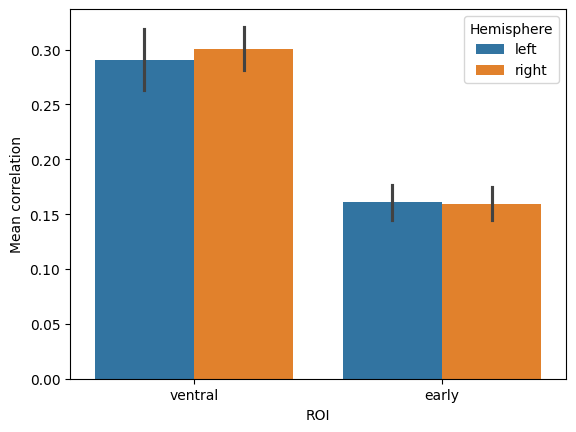

In [75]:
# Chose relevant ROIs and plot using make_rois_encoding_plot()
rois = ['FFA-1', 'PPA', 'EBA']
make_rois_encoding_plot(features_train, features_test, rois, idxs_train, idxs_test)

ROI-wise plots
 We summarized the performance of the encoding model by averaging across all vertices in a ROI.

In [ ]:
all_rois = ["all-vertices", "V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]

roi_encoding_scores = {}

for this_roi in all_rois:
    roi_encoding_scores[this_roi] = {}
    for hemi in ['left', 'right']:
        if hemi == 'left':
            corrmap = lh_correlation_effNet
        elif hemi == 'right':
            corrmap = rh_correlation_effNet
        this_roi_mask, _ = get_roi_mask(this_roi, hemi, subj_dir)
        roi_encoding_corrmap = corrmap[this_roi_mask != 0]
        mean_corr = np.mean(roi_encoding_corrmap)
        roi_encoding_scores[this_roi][hemi] = mean_corr

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


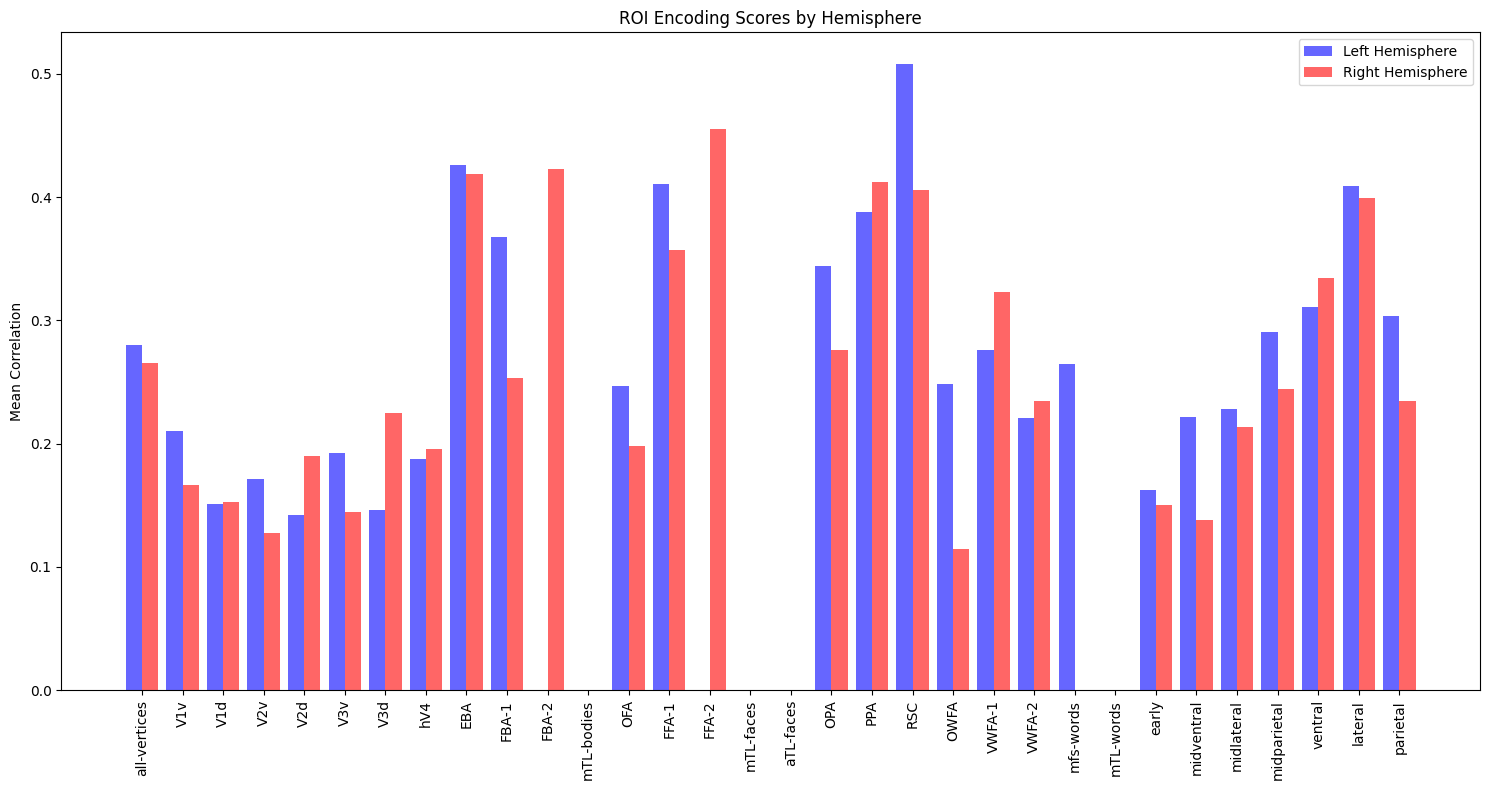

In [ ]:
# Plot roi_encoding_scores.
# Expected structure: {roi_name: {'left': mean_corr, 'right': mean_corr}}

# Prepare data for plotting
rois = list(roi_encoding_scores.keys())
left_scores = [roi_encoding_scores[roi]['left'] for roi in rois]
right_scores = [roi_encoding_scores[roi]['right'] for roi in rois]

# Define the positions of the bars
bar_width = 0.4
x = np.arange(len(rois))  # the label locations

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot left hemisphere scores
ax.bar(x - bar_width/2, left_scores, bar_width, label='Left Hemisphere', alpha=0.6, color='b')
# Plot right hemisphere scores
ax.bar(x + bar_width/2, right_scores, bar_width, label='Right Hemisphere', alpha=0.6, color='r')

# Set labels and title
ax.set_ylabel('Mean Correlation')
ax.set_title('ROI Encoding Scores by Hemisphere')
ax.set_xticks(x)
ax.set_xticklabels(rois, rotation=90)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
def fit_and_predict(subj, features_train, features_test, train_idxs, test_idxs,
                    regression=LinearRegression()):

  #Given a subject ID, train and test features, and a regression model,
  #this function loads the relevant fMRI data, fits the regression on it
  #and computes the prediction accuracy of the fitted model.
  #It also returns the fitted regressions



  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  # Load fmri for both hemispheres of the subject
  lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
  rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

  # Make train/test splits for the fMRI data for the two hemispheres

  lh_fmri_train = lh_fmri[idxs_train]
  lh_fmri_test = lh_fmri[idxs_test]
  rh_fmri_train = rh_fmri[idxs_train]
  rh_fmri_test = rh_fmri[idxs_test]

  del lh_fmri, rh_fmri # Delete unused fMRI data to save memory

  # Make new instances of the linear reg class passed as input
  reg_lh = clone(regression) # This makes a new instance of the regression
  reg_rh = clone(regression) # This makes a new instance of the regression



  # Fit linear regressions on the training data
  reg_lh = reg_lh.fit(features_train, lh_fmri_train)
  reg_rh = reg_rh.fit(features_train, rh_fmri_train)
  # Use fitted linear regressions to predict the validation and test fMRI data
  lh_fmri_test_pred = reg_lh.predict(features_test)
  rh_fmri_test_pred = reg_rh.predict(features_test)


  # Correlate predicted and ground-truth values for each fMRI vertex
  lh_corrs = np.zeros(lh_fmri_test.shape[1])
  rh_corrs = np.zeros(rh_fmri_test.shape[1])

  for v in range(lh_fmri_test.shape[1]):
      lh_corrs[v] = np.corrcoef(lh_fmri_test[:, v], lh_fmri_test_pred[:, v])[0, 1]

  for v in range(rh_fmri_test.shape[1]):
      rh_corrs[v] = np.corrcoef(rh_fmri_test[:, v], rh_fmri_test_pred[:, v])[0, 1]

  return lh_corrs, rh_corrs, reg_lh, reg_rh


Making a custom plotting function


In [ ]:
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

prediction_df = []
for subj in tqdm(range(1, 9)):

  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  lh_corrs, rh_corrs, _, _ = fit_and_predict(subj, features_train, features_test,
                                             idxs_train, idxs_test)

  roi1_lh_mask, _ = get_roi_mask(roi_1, 'left', subj_dir)
  roi2_lh_mask, _ = get_roi_mask(roi_2, 'left', subj_dir)
  roi1_rh_mask, _ = get_roi_mask(roi_1, 'right', subj_dir)
  roi2_rh_mask, _ = get_roi_mask(roi_2, 'right', subj_dir)

  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[roi1_lh_mask!=0]),
      'hemisphere': 'left',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[roi1_rh_mask!=0]),
      'hemisphere': 'right',
      'roi': roi_1
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(lh_corrs[roi2_lh_mask!=0]),
      'hemisphere': 'left',
      'roi': roi_2
  })
  prediction_df.append({
      'subject': f'subj-{subj:02d}',
      f'mean_corr': np.mean(rh_corrs[roi2_rh_mask!=0]),
      'hemisphere': 'right',
      'roi': roi_2
  })

prediction_df = pd.DataFrame(prediction_df)

100%|██████████| 8/8 [02:33<00:00, 19.22s/it]


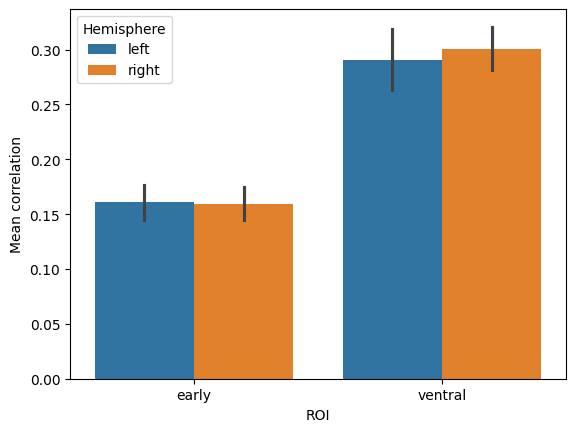

In [ ]:
try:
  import seaborn as sns
except:
  !pip install seaborn
  import seaborn as sns

sns.barplot(x='roi', y='mean_corr', hue='hemisphere',
            errorbar='se', data=prediction_df)
plt.xlabel('ROI')
plt.ylabel('Mean correlation')
plt.legend(title='Hemisphere')
plt.show()

In [ ]:
def make_rois_encoding_plot(features_train, features_test, rois,
                            idxs_train, idxs_test):

    # COMMENT OUT 'raise NotImplementedError()' AND REPLACE WITH YOUR SOLUTION
    roi_1 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
    roi_2 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

    prediction_df = []
    for subj in tqdm(range(1, 9)):

        subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

        lh_corrs, rh_corrs, _, _ = fit_and_predict(subj, features_train, features_test,
                                                   idxs_train, idxs_test)

        roi1_lh_mask, _ = get_roi_mask(roi_1, 'left', subj_dir)
        roi2_lh_mask, _ = get_roi_mask(roi_2, 'left', subj_dir)
        roi1_rh_mask, _ = get_roi_mask(roi_1, 'right', subj_dir)
        roi2_rh_mask, _ = get_roi_mask(roi_2, 'right', subj_dir)

        prediction_df.append({
            'subject': f'subj-{subj:02d}',
            'mean_corr': np.mean(lh_corrs[roi1_lh_mask != 0]),
            'hemisphere': 'left',
            'roi': roi_1
        })
        prediction_df.append({
            'subject': f'subj-{subj:02d}',
            'mean_corr': np.mean(rh_corrs[roi1_rh_mask != 0]),
            'hemisphere': 'right',
            'roi': roi_1
        })
        prediction_df.append({
            'subject': f'subj-{subj:02d}',
            'mean_corr': np.mean(lh_corrs[roi2_lh_mask != 0]),
            'hemisphere': 'left',
            'roi': roi_2
        })
        prediction_df.append({
            'subject': f'subj-{subj:02d}',
            'mean_corr': np.mean(rh_corrs[roi2_rh_mask != 0]),
            'hemisphere': 'right',
            'roi': roi_2
        })

    prediction_df = pd.DataFrame(prediction_df)

    # Plotting the results using seaborn
    try:
        import seaborn as sns
    except ImportError:
        !pip install seaborn
        import seaborn as sns

    sns.barplot(x='roi', y='mean_corr', hue='hemisphere',
                errorbar='se', data=prediction_df)
    plt.xlabel('ROI')
    plt.ylabel('Mean correlation')
    plt.legend(title='Hemisphere')
    plt.show()


Another model: Vision Transformer (ViT) - vit_b_16

In [ ]:

import torch
import torchvision

subj = 1
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

# Download model, make model instance, put it on the right device
# Get the pretrained weights for Vision Transformer (ViT) - vit_b_16
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# The weights contain the preprocessing transforms
vit_transforms = vit_weights.transforms()

#make dataset with the vit transforms
batch_size = 50 #@param

# Get the paths of all image files
imgs_paths = [stim_dir + '/' + x for x in sorted(os.listdir(stim_dir))]

# The DataLoaders use the ImageDataset class we defined earlier
vit_train_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_train, transform=vit_transforms),
    batch_size=batch_size
)
vit_test_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_test, transform=vit_transforms),
    batch_size=batch_size
)

# Instantiate the ViT model
vit_model = torchvision.models.vit_b_16(weights=vit_weights)

# Put model on GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model.to(device)

# Use model in evaluation mode (i.e., dropout is not applied, etc.)
vit_model.eval()

print(device)


vit_train_nodes, _ = get_graph_node_names(vit_model)
print(vit_train_nodes)

vit_model_layer = "encoder.layers.encoder_layer_11"
vit_feature_extractor = create_feature_extractor(vit_model, return_nodes=[vit_model_layer])
vit_pca = fit_pca(vit_feature_extractor, vit_train_imgs_dataloader, batch_size,
              n_components=min(batch_size, 50))
vit_features_train = extract_features(vit_feature_extractor, vit_train_imgs_dataloader,vit_pca)
vit_features_test = extract_features(vit_feature_extractor, vit_test_imgs_dataloader, vit_pca)

vit_lh_corrs, vit_rh_corrs, _, _ = fit_and_predict(subj, vit_features_train, vit_features_test, idxs_train, idxs_test,
                    regression=LinearRegression())





Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 102MB/s] 


cuda
['x', 'getattr', 'getitem', 'getitem_1', 'getitem_2', 'getitem_3', 'eq', '_assert', 'eq_1', '_assert_1', 'floordiv', 'floordiv_1', 'conv_proj', 'mul', 'reshape', 'permute', 'getattr_1', 'getitem_4', 'class_token', 'expand', 'cat', 'encoder.dim', 'encoder.eq', 'encoder.getattr', 'encoder._assert', 'encoder.encoder_pos_embedding', 'encoder.add', 'encoder.dropout', 'encoder.layers.encoder_layer_0.dim', 'encoder.layers.encoder_layer_0.eq', 'encoder.layers.encoder_layer_0.getattr', 'encoder.layers.encoder_layer_0._assert', 'encoder.layers.encoder_layer_0.ln', 'encoder.layers.encoder_layer_0.self_attention', 'encoder.layers.encoder_layer_0.getitem', 'encoder.layers.encoder_layer_0.getitem_1', 'encoder.layers.encoder_layer_0.dropout', 'encoder.layers.encoder_layer_0.add', 'encoder.layers.encoder_layer_0.ln_1', 'encoder.layers.encoder_layer_0.mlp', 'encoder.layers.encoder_layer_0.add_1', 'encoder.layers.encoder_layer_1.dim', 'encoder.layers.encoder_layer_1.eq', 'encoder.layers.encoder_lay

100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Plotting Brainmap

In [ ]:
# Plot brain map for subject 1 left hemis
view = plot_brainmap(vit_lh_corrs, 'all-vertices', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(vit_lh_corrs, 'ventral', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(vit_lh_corrs, 'early', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Plot brain map for subject 1 right hemis
view = plot_brainmap(vit_rh_corrs, 'all-vertices', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Plot brain map for subject 1 right hemis
view = plot_brainmap(vit_rh_corrs, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Plot brain map for subject 1 right hemis
view = plot_brainmap(vit_rh_corrs, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

Contrast between EfficientNet and Vitb16

In [ ]:
contrast_lh = lh_correlation_effNet - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'all-vertices', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_lh = lh_correlation_effNet - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'ventral', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_lh = lh_correlation_effNet - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'early', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh = rh_correlation_effNet - vit_rh_corrs
view = plot_brainmap(contrast_rh, 'all-vertices', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh = rh_correlation_effNet - vit_rh_corrs
view = plot_brainmap(contrast_rh, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh = rh_correlation_effNet - vit_rh_corrs
view = plot_brainmap(contrast_rh, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 8/8 [00:38<00:00,  4.75s/it]


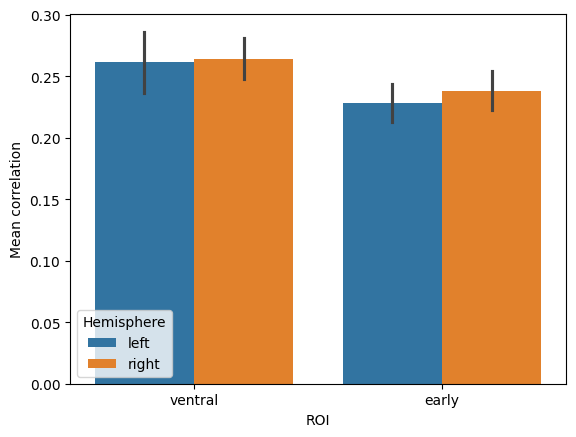

In [ ]:
rois = ['FFA-1', 'PPA', 'early']
# Chose relevant ROIs and plot using make_rois_encoding_plot()
make_rois_encoding_plot(vit_features_train, vit_features_test, rois, idxs_train, idxs_test)

Another CNN Model: ResNet18

In [ ]:

# Download model, make model instance, put it on the right device
resNet_weights = torchvision.models.ResNet18_Weights.DEFAULT
resNet_transforms = resNet_weights.transforms()
resNet_model = torchvision.models.resnet18(weights=resNet_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNet_model.to(device)
resNet_model.eval()

# Make dataloader with new transforms
resNet_train_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_train, transform=resNet_transforms),
    batch_size=batch_size
)
resNet_test_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_test, transform=resNet_transforms),
    batch_size=batch_size
)

# Extract features on the training and testing sets (with PCA dim reduction)
resNet_model_layer = "avgpool"
resNet_feature_extractor = create_feature_extractor(resNet_model, return_nodes=[resNet_model_layer])
resNet_pca = fit_pca(resNet_feature_extractor, resNet_train_imgs_dataloader, batch_size,
                     n_components=min(batch_size, 50))
resNet_features_train = extract_features(resNet_feature_extractor, resNet_train_imgs_dataloader, resNet_pca)
resNet_features_test = extract_features(resNet_feature_extractor, resNet_test_imgs_dataloader, resNet_pca)

# Get lh_corrs & rh_corrs for subject 1 using the fit_and_predict() function
subj = 1
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')
resNet_lh_corrs, resNet_rh_corrs, _, _ = fit_and_predict(subj, resNet_features_train,
                                           resNet_features_test,
                                           idxs_train, idxs_test)

# Plot brain map for subject 1
map_type = 'infl' # ['infl', 'pial', 'sphere', 'white', 'flat']
hemisphere = 'left'
roi = "all-vertices" # ["all-vertices", "V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]

# Map the correlation results onto the brain surface map
if hemisphere == 'left':
    corrmap = resNet_lh_corrs
elif hemisphere == 'right':
    corrmap = resNet_rh_corrs



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


In [ ]:
# Plot brain map for subject 1 left hemis
view = plot_brainmap(resNet_lh_corrs, 'all-vertices', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(resNet_lh_corrs, 'ventral', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(resNet_lh_corrs, 'early', map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Plot brain map for subject 1 right hemis
view = plot_brainmap(resNet_rh_corrs, 'all-vertices', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(resNet_rh_corrs, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
view = plot_brainmap(resNet_rh_corrs, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

Contrast between Resnet18 and Vitb16

In [ ]:
contrast_lh = resNet_lh_corrs - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'all-vertices', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_lh = resNet_lh_corrs - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'ventral', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_lh = resNet_lh_corrs - vit_lh_corrs
view = plot_brainmap(contrast_lh, 'early', map_type, hemisphere, subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh =  resNet_rh_corrs- vit_rh_corrs
view = plot_brainmap(contrast_rh, 'all-vertices', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh =  resNet_rh_corrs- vit_rh_corrs
view = plot_brainmap(contrast_rh, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh =  resNet_rh_corrs- vit_rh_corrs
view = plot_brainmap(contrast_rh, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 8/8 [00:37<00:00,  4.66s/it]


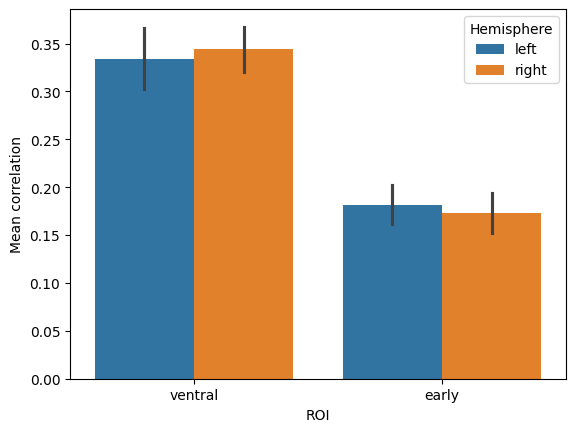

In [ ]:
# Chose relevant ROIs and plot using make_rois_encoding_plot()
rois = ['FFA-1', 'PPA', 'EBA']
make_rois_encoding_plot(resNet_features_train, resNet_features_test, rois, idxs_train, idxs_test)


Contrast between the two CNN models: Resnet18 and EfficientNet

In [ ]:
contrast_rh =  resNet_rh_corrs- rh_correlation_effNet
view = plot_brainmap(contrast_rh, 'ventral', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh =  resNet_rh_corrs- rh_correlation_effNet
view = plot_brainmap(contrast_rh, 'all-vertices', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_rh =  resNet_rh_corrs- rh_correlation_effNet
view = plot_brainmap(contrast_rh, 'early', map_type, 'right', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
contrast_lh = resNet_lh_corrs - lh_correlation_effNet
view = plot_brainmap(contrast_lh, 'all-vertices', map_type, 'left', subj_dir)
view

In [ ]:
contrast_lh = resNet_lh_corrs - lh_correlation_effNet
view = plot_brainmap(contrast_lh, 'ventral', map_type, 'left', subj_dir)
view

In [ ]:
contrast_lh = resNet_lh_corrs - lh_correlation_effNet
view = plot_brainmap(contrast_lh, 'early', map_type, 'left', subj_dir)
view